# Get data from server

In [1]:
import pymysql
import pandas as pd

from dotenv import load_dotenv
from os import getenv

In [2]:
load_dotenv(dotenv_path = '.env')

conn = pymysql.connect(host = getenv('host'),
                       port = int(getenv('port')),
                       user = getenv('user'),
                       passwd = getenv('password'),
                       db = 'financial')

In [3]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:

    table = pd.read_sql("select * from `%s`" % name, conn)
    table.to_csv('tables/%s.csv' % name, index = False)
    print(table.tail(2))
    print('')

      account_id  district_id         frequency        date
4498       11362           67  POPLATEK MESICNE  1995-10-14
4499       11382           74  POPLATEK MESICNE  1995-08-20

     card_id  disp_id     type      issued
890     1239    13442   junior  1998-02-02
891     1247    13660  classic  1995-06-13

      client_id gender  birth_date  district_id
5367      13971      F  1962-10-19           67
5368      13998      F  1953-08-12           74

      disp_id  client_id  account_id   type
5367    13663      13971       11362  OWNER
5368    13690      13998       11382  OWNER

    district_id       A2             A3      A4  A5  A6  A7  A8  A9   A10  \
75           76  Sumperk  north Moravia  127369  31  32  13   2   7  51.2   
76           77   Vsetin  north Moravia  148545   8  35  12   3   4  53.5   

     A11  A12   A13  A14     A15   A16  
75  8369  4.7  5.88  107  3736.0  2807  
76  8909  4.0  5.56  113  3460.0  3590  

     loan_id  account_id        date  amount  duration 

In [4]:
#Close connection
conn.close()

# Load in data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

In [89]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:
    exec("%s = pd.read_csv('tables/%s.csv')" % (name,name))

    exec("print(%s.tail(2))" % name)
    print('')

      account_id  district_id         frequency        date
4498       11362           67  POPLATEK MESICNE  1995-10-14
4499       11382           74  POPLATEK MESICNE  1995-08-20

     card_id  disp_id     type      issued
890     1239    13442   junior  1998-02-02
891     1247    13660  classic  1995-06-13

      client_id gender  birth_date  district_id
5367      13971      F  1962-10-19           67
5368      13998      F  1953-08-12           74

      disp_id  client_id  account_id   type
5367    13663      13971       11362  OWNER
5368    13690      13998       11382  OWNER

    district_id       A2             A3      A4  A5  A6  A7  A8  A9   A10  \
75           76  Sumperk  north Moravia  127369  31  32  13   2   7  51.2   
76           77   Vsetin  north Moravia  148545   8  35  12   3   4  53.5   

     A11  A12   A13  A14     A15   A16  
75  8369  4.7  5.88  107  3736.0  2807  
76  8909  4.0  5.56  113  3460.0  3590  

     loan_id  account_id        date  amount  duration 

/home/steve/Desktop/Unit5_Project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# SQL merges

In [90]:
# 'A' stands for contract finished, no problems,
# 'B' stands for contract finished, loan not payed,
# 'C' stands for running contract, OK so far,
# 'D' stands for running contract, client in debt

loan['status2'] = loan.status

loan.loc[loan['status2']=='C','status2'] = 'A'
loan.loc[loan['status2']=='B','status2'] = 'D'

In [91]:
#Join card and disp
disp_card = disp.drop(columns=['type']).merge(card,on='disp_id').drop(columns=['card_id','disp_id'])

#Join client and disp
disp_cc = disp_card.merge(client,on='client_id').drop(columns=['client_id','district_id'])

#Join disp and account
account_disp = account.merge(disp_cc,on='account_id')

In [92]:
account_disp.head(2)

,account_id,district_id,frequency,date,type,issued,gender,birth_date
0,7,60,POPLATEK MESICNE,1996-11-24,gold,1998-10-16,M,1935-10-16
1,14,47,POPLATEK MESICNE,1996-11-27,classic,1998-03-13,M,1942-12-28


In [94]:
#inner join order onto loan
loan_o = loan.merge(order,on='account_id',
                    suffixes=('_loan','_order')).drop(columns=['order_id','account_to','k_symbol',
                                                               'amount_loan','duration','payments'])

#inner join trans onto loan
loan_ot = loan_o.merge(trans.drop(columns=['date','trans_id','bank','account','k_symbol','operation']),
                       on='account_id',suffixes=('_order','_trans'))

In [95]:
loan_ot.head()

,loan_id,account_id,date,status,status2,bank_to,amount_order,type,amount,balance
0,4959,2,1994-01-05,A,A,ST,3372.7,PRIJEM,1100,1100
1,4959,2,1994-01-05,A,A,ST,3372.7,PRIJEM,20236,21336
2,4959,2,1994-01-05,A,A,ST,3372.7,PRIJEM,20236,45286
3,4959,2,1994-01-05,A,A,ST,3372.7,PRIJEM,20236,54631
4,4959,2,1994-01-05,A,A,ST,3372.7,PRIJEM,30354,67530


In [96]:
#Join final loan with final account
loan_account = loan_ot.merge(account_disp,on='account_id',suffixes=('_loan','_account'))

In [97]:
loan_account.head(2)

,loan_id,account_id,date_loan,status,status2,bank_to,amount_order,type_loan,amount,balance,district_id,frequency,date_account,type_account,issued,gender,birth_date
0,4986,97,1997-08-10,A,A,ST,1436.0,PRIJEM,900,900,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28
1,4986,97,1997-08-10,A,A,ST,1436.0,PRIJEM,17928,18828,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28


In [98]:
#Join final loan/account with district
loan_final = loan_account.merge(district,on='district_id').drop(columns=['A2','A12','A15'])

In [99]:
loan_final.head(2)

,loan_id,account_id,date_loan,status,status2,bank_to,amount_order,type_loan,amount,balance,district_id,frequency,date_account,type_account,issued,gender,birth_date,A3,A4,A5,A6,A7,A8,A9,A10,A11,A13,A14,A16
0,4986,97,1997-08-10,A,A,ST,1436.0,PRIJEM,900,900,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
1,4986,97,1997-08-10,A,A,ST,1436.0,PRIJEM,17928,18828,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347


In [262]:
data = loan_final.drop(columns=['status','loan_id','account_id','district_id',
                                'date_loan','date_account','issued','birth_date'])

In [263]:
data.columns

Index(['status2', 'bank_to', 'amount_order', 'type_loan', 'amount', 'balance',
       'frequency', 'type_account', 'gender', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16'],
      dtype='object')

In [264]:
data.nunique()

status2             2
bank_to            13
amount_order      339
type_loan           3
amount           7054
balance         36286
frequency           3
type_account        3
gender              2
A3                  8
A4                 60
A5                 44
A6                 30
A7                 16
A8                  6
A9                 11
A10                54
A11                59
A13                56
A14                36
A16                60
dtype: int64

In [265]:
data.shape

(104904, 21)

In [266]:
binary_variables = ['gender']

continuous_variables = [#'amount_loan', 'duration', 'payments', 
                        'amount_order','amount', 'balance',
                        'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                        'A10', 'A11', 'A13', 'A14', 
                        'A16']

target_variables = ['status2']

nominal_cat_variables = [x for x in data.columns.to_list() if x not in set(binary_variables + continuous_variables + target_variables)]

In [267]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#Set x and y variables
x = data.drop(columns = 'status2')
y = data.status2

#Train test split
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size = 0.2,
                                                    random_state = 42)

data_transformer = ColumnTransformer(transformers=[
    ('continuous', 'passthrough', continuous_variables),
    ('binary', OrdinalEncoder(), binary_variables),
    ('nominal', OneHotEncoder(sparse=False), nominal_cat_variables)],
                                    remainder = 'drop')

# Feature Selection

In [268]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [269]:
variance_picking = Pipeline([('scaler', MinMaxScaler()),
                            ('var_thres', VarianceThreshold(threshold=0.1))])

variance_picking.fit(x_train[continuous_variables])

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('var_thres', VarianceThreshold(threshold=0.1))],
         verbose=False)

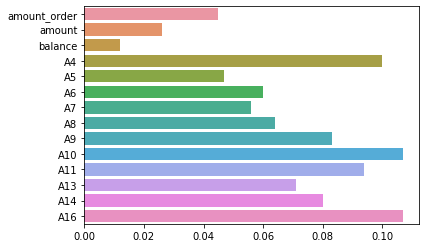

In [270]:
sns.barplot(variance_picking.named_steps['var_thres'].variances_.round(3),continuous_variables)

In [271]:
new_continuous_variables = [continuous_variables[value] 
                            for value in variance_picking.named_steps['var_thres'].get_support(indices=True)]
new_continuous_variables

# Univariate Selection

['A4', 'A10', 'A16']

# Univariate Selection

In [272]:
combined_cat_variables = binary_variables + nominal_cat_variables
combined_cat_variables

['gender', 'bank_to', 'type_loan', 'frequency', 'type_account', 'A3']

In [273]:
from sklearn.feature_selection import chi2, SelectKBest

chi2_pipe_k = Pipeline([('ordinal_transform', OrdinalEncoder()),
                        ('SelectK', SelectKBest(score_func = chi2,
                                                k = 2))])

chi2_pipe_k.fit(x_train[combined_cat_variables],y_train)

Pipeline(memory=None,
         steps=[('ordinal_transform',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('SelectK',
                 SelectKBest(k=2,
                             score_func=<function chi2 at 0x7f9faff67e60>))],
         verbose=False)

In [274]:
new_categorical_variables = [combined_cat_variables[value] 
                               for value in chi2_pipe_k.named_steps['SelectK'].get_support(indices=True)]
new_categorical_variables

['gender', 'type_account']

In [275]:
from sklearn.feature_selection import SelectFwe

chi2_pipe_fwe = Pipeline([('ordinal_transform', OrdinalEncoder()),
                         ('Selectfwe', SelectFwe(score_func = chi2, 
                                                 alpha = 0.05))])

chi2_pipe_fwe.fit(x_train[new_categorical_variables], y_train)

Pipeline(memory=None,
         steps=[('ordinal_transform',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('Selectfwe',
                 SelectFwe(alpha=0.05,
                           score_func=<function chi2 at 0x7f9faff67e60>))],
         verbose=False)

In [276]:
final_categorical_variables = [new_categorical_variables[value] 
                               for value in chi2_pipe_fwe.named_steps['Selectfwe'].get_support(indices=True)]
final_categorical_variables

['gender', 'type_account']

# ANOVA

In [277]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

anova_pipe = Pipeline([('scaler', StandardScaler()),
                        ('anova', SelectKBest(score_func = f_classif,
                                             k = 'all'))])

anova_pipe.fit(x_train[new_continuous_variables], y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('anova',
                 SelectKBest(k='all',
                             score_func=<function f_classif at 0x7f9faff7c8c0>))],
         verbose=False)

In [278]:
anova_pipe_fwe = Pipeline([('scaler', StandardScaler()),
                           ('select', SelectFwe(score_func = f_classif,
                                                alpha = 0.05))])

anova_pipe_fwe.fit(x_train[new_continuous_variables], y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('select',
                 SelectFwe(alpha=0.05,
                           score_func=<function f_classif at 0x7f9faff7c8c0>))],
         verbose=False)

In [279]:
final_continuous_variables = [new_continuous_variables[value] 
                              for value in anova_pipe_fwe.named_steps['select'].get_support(indices=True)]
final_continuous_variables

['A4', 'A10', 'A16']

# Modelling

In [280]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [281]:
from sklearn.compose import ColumnTransformer

data_transformer = ColumnTransformer(transformers = [
                                    ('continuous','passthrough', final_continuous_variables),
                                    ('binary', OrdinalEncoder(), final_categorical_variables)],
                                    remainder = 'drop')

## Null Model

In [282]:
from sklearn.tree import DecisionTreeClassifier

dt_null = Pipeline(steps= [('transform', data_transformer),
                           ('dt',DecisionTreeClassifier(random_state=42))])

dt_null.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('continuous', 'passthrough',
                                                  ['A4', 'A10', 'A16']),
                                                 ('binary',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['gender', 'type_account'])],
                                   verbose=False)),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_

In [283]:
y_train_dt = dt_null.predict(x_train)
y_test_dt = dt_null.predict(x_test)

In [284]:
print(recall_score(y_train, y_train_dt, labels=['A','D'],pos_label='A'))
print(recall_score(y_test, y_test_dt, labels=['A','D'],pos_label='A'))

0.998532892790216
0.9983262774441272


In [285]:
print(confusion_matrix(y_train, y_train_dt))
print(confusion_matrix(y_test, y_test_dt))

[[80993   119]
 [  421  2390]]
[[20280    34]
 [  104   563]]


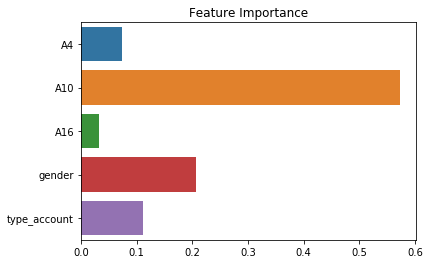

In [286]:
final_columns = final_continuous_variables + final_categorical_variables

sns.barplot(dt_null[-1].feature_importances_.round(3),
            final_columns)

plt.title('Feature Importance')
plt.show()

## Random Forest

In [288]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_pipe = Pipeline([('transform', data_transformer),
                    ('rf', RandomForestClassifier(n_estimators = 100,
                                                  bootstrap = True,
                                                  random_state = 42))])

params = [{'rf__max_depth': [5, 10, 15, None],
           'rf__max_leaf_nodes': [50, 100, 150, None],
           'rf__max_features': ['auto', 'log2'],
           'rf__max_samples': [0.7, 0.8, 0.9, None]}]

rf_gridsearch = GridSearchCV(rf_pipe, params, n_jobs = -1, cv = 3)

In [289]:
rf_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('continuous',
                                                                         'passthrough',
                                                                         ['A4',
                                                                          'A10',
                                                                          'A16']),
                                                                        ('binary',
                                                     

In [290]:
rf_gridsearch.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': 50,
 'rf__max_samples': 0.7}

In [291]:
final_rf = rf_gridsearch.best_estimator_
y_train_rf = final_rf.predict(x_train)
y_test_rf = final_rf.predict(x_test)

In [292]:
print(recall_score(y_train, y_train_rf, labels=['A','D'],pos_label='A'))
print(recall_score(y_test, y_test_rf, labels=['A','D'],pos_label='A'))

0.998532892790216
0.9983262774441272


In [293]:
print(confusion_matrix(y_train, y_train_rf))
print(confusion_matrix(y_test, y_test_rf))

[[80993   119]
 [  421  2390]]
[[20280    34]
 [  104   563]]


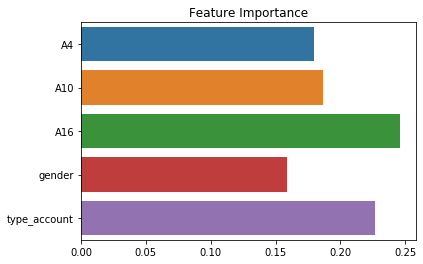

In [312]:
final_columns = final_continuous_variables + final_categorical_variables

sns.barplot(final_rf[-1].feature_importances_.round(3),
            final_columns)

plt.title('Feature Importance')
plt.show()

# AdaBoost

In [307]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline(steps= [('transform', data_transformer),
                           ('ada', AdaBoostClassifier(random_state = 42))])

params = [{'ada__learning_rate': [0.1, 0.5, 1],
           'ada__n_estimators': [10, 50, 100]}]

ada_gridsearch = GridSearchCV(ada_pipe, params, n_jobs = -1, cv = 3)

ada_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('continuous',
                                                                         'passthrough',
                                                                         ['A4',
                                                                          'A10',
                                                                          'A16']),
                                                                        ('binary',
                                                     

In [308]:
ada_gridsearch.best_params_

{'ada__learning_rate': 1, 'ada__n_estimators': 100}

In [309]:
final_ada = ada_gridsearch.best_estimator_
y_train_ada = final_ada.predict(x_train)
y_test_ada = final_ada.predict(x_test)

In [310]:
print(recall_score(y_train, y_train_ada, labels=['A','D'],pos_label='A'))
print(recall_score(y_test, y_test_ada, labels=['A','D'],pos_label='A'))

1.0
1.0


In [311]:
print(confusion_matrix(y_train, y_train_ada))
print(confusion_matrix(y_test, y_test_ada))

[[81112     0]
 [  743  2068]]
[[20314     0]
 [  188   479]]


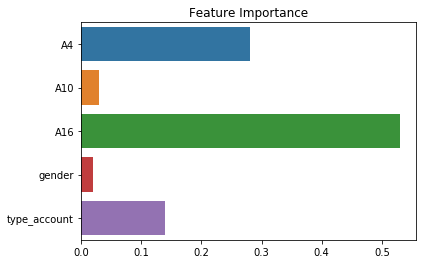

In [313]:
final_columns = final_continuous_variables + final_categorical_variables

sns.barplot(final_ada[-1].feature_importances_.round(3),
            final_columns)

plt.title('Feature Importance')
plt.show()

# Gradient Boost

In [321]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipe = Pipeline([('transform', data_transformer),
                    ('gb', GradientBoostingClassifier(random_state = 42))])

params = [{'gb__max_depth': [5, 10, 15, None],
           'gb__max_leaf_nodes': [50, 100, 150, None],
           'gb__max_features': ['auto', 'log2'],
           'gb__validation_fraction': [0.1, 0.3, 0.6],
           'gb__n_iter_no_change': [2, 5, None]}]

gb_gridsearch = GridSearchCV(gb_pipe, params, n_jobs = -1, cv = 3)

gb_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('continuous',
                                                                         'passthrough',
                                                                         ['A4',
                                                                          'A10',
                                                                          'A16']),
                                                                        ('binary',
                                                     

In [323]:
gb_gridsearch.best_params_

{'gb__max_depth': 5,
 'gb__max_features': 'auto',
 'gb__max_leaf_nodes': 50,
 'gb__n_iter_no_change': 2,
 'gb__validation_fraction': 0.1}

In [324]:
final_gb = gb_gridsearch.best_estimator_
y_train_gb = final_gb.predict(x_train)
y_test_gb = final_gb.predict(x_test)

In [325]:
print(recall_score(y_train, y_train_gb, labels=['A','D'],pos_label='A'))
print(recall_score(y_test, y_test_gb, labels=['A','D'],pos_label='A'))

0.998532892790216
0.9983262774441272


In [326]:
print(confusion_matrix(y_train, y_train_gb))
print(confusion_matrix(y_test, y_test_gb))

[[80993   119]
 [  421  2390]]
[[20280    34]
 [  104   563]]


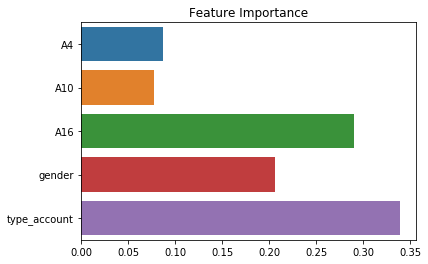

In [384]:
final_columns = final_continuous_variables + final_categorical_variables

sns.barplot(final_gb[-1].feature_importances_.round(3),
            final_columns)

plt.title('Feature Importance')
plt.show()

# Extreme Gradient Boost (XGBoost)

In [334]:
import xgboost as xgb

xgb_pipe = Pipeline([('transform', data_transformer),
                    ('xgb', xgb.XGBClassifier(scale_pos_weight = 1,
                                              random_state = 42))])

params = [{'xgb__max_depth': [3, 6, 10, None],
           'xgb__learning_rate': [0.1, 0.3, 0.5],
           'xgb__colsample_bytree': [0.5, 0.7, 0.9],
           'xgb__n_estimators': [50, 100, 150]}]

xgb_gridsearch = GridSearchCV(xgb_pipe, params, n_jobs = -1, cv = 3)

xgb_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('continuous',
                                                                         'passthrough',
                                                                         ['A4',
                                                                          'A10',
                                                                          'A16']),
                                                                        ('binary',
                                                     

In [335]:
xgb_gridsearch.best_params_

{'xgb__colsample_bytree': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 150}

In [336]:
final_xgb = xgb_gridsearch.best_estimator_
y_train_xgb = final_xgb.predict(x_train)
y_test_xgb = final_xgb.predict(x_test)

In [337]:
print(recall_score(y_train, y_train_xgb, labels=['A','D'],pos_label='A'))
print(recall_score(y_test, y_test_xgb, labels=['A','D'],pos_label='A'))

0.998532892790216
0.9983262774441272


In [338]:
print(confusion_matrix(y_train, y_train_xgb))
print(confusion_matrix(y_test, y_test_xgb))

[[80993   119]
 [  421  2390]]
[[20280    34]
 [  104   563]]


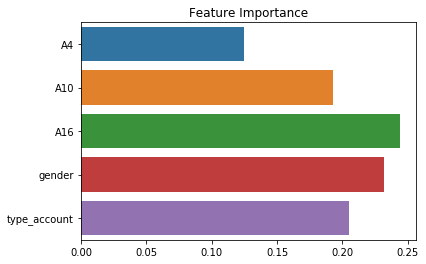

In [385]:
final_columns = final_continuous_variables + final_categorical_variables

sns.barplot(final_xgb[-1].feature_importances_.round(3),
            final_columns)

plt.title('Feature Importance')
plt.show()

# CatBoost

In [364]:
cat_df = data.copy()

cat_df.head()

,status2,bank_to,amount_order,type_loan,amount,balance,frequency,type_account,gender,A3,A4,A5,A6,A7,A8,A9,A10,A11,A13,A14,A16
0,A,ST,1436.0,PRIJEM,900,900,POPLATEK MESICNE,classic,M,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
1,A,ST,1436.0,PRIJEM,17928,18828,POPLATEK MESICNE,classic,M,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
2,A,ST,1436.0,PRIJEM,26892,50266,POPLATEK MESICNE,classic,M,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
3,A,ST,1436.0,PRIJEM,17928,54546,POPLATEK MESICNE,classic,M,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
4,A,ST,1436.0,PRIJEM,17928,60094,POPLATEK MESICNE,classic,M,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347


In [365]:
from sklearn.preprocessing import LabelEncoder

cat_train_le = LabelEncoder()
cat_train_le.fit(cat_df['status2'])

cat_df['target'] = cat_train_le.transform(cat_df['status2'])

In [366]:
cat_x_train, cat_x_test, cat_y_train, cat_y_test = train_test_split(cat_df[final_columns],
                                                    cat_df['target'],
                                                    random_state = 42)

In [367]:
#Set up categorical columns
cat_columns = ['gender', 'type_account']
cat_columns

['gender', 'type_account']

In [379]:
import catboost
from catboost import Pool, CatBoostClassifier

train_pool = Pool(cat_x_train, 
                  cat_y_train, 
                  cat_features=cat_columns)

test_pool = Pool(cat_x_test, 
                 cat_y_test, 
                 cat_features=cat_columns)

cb_model = CatBoostClassifier(random_state = 42,
                              early_stopping_rounds = 10)

cb_model.fit(train_pool, eval_set = test_pool)

Learning rate set to 0.09315
0:	learn: 0.4505846	test: 0.4503657	best: 0.4503657 (0)	total: 71.6ms	remaining: 1m 11s
1:	learn: 0.2872927	test: 0.2870735	best: 0.2870735 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 0.1970679	test: 0.1968272	best: 0.1968272 (2)	total: 250ms	remaining: 1m 23s
3:	learn: 0.1255441	test: 0.1254909	best: 0.1254909 (3)	total: 323ms	remaining: 1m 20s
4:	learn: 0.0854741	test: 0.0855825	best: 0.0855825 (4)	total: 392ms	remaining: 1m 17s
5:	learn: 0.0605381	test: 0.0608193	best: 0.0608193 (5)	total: 468ms	remaining: 1m 17s
6:	learn: 0.0440256	test: 0.0443965	best: 0.0443965 (6)	total: 557ms	remaining: 1m 19s
7:	learn: 0.0375789	test: 0.0378597	best: 0.0378597 (7)	total: 631ms	remaining: 1m 18s
8:	learn: 0.0316541	test: 0.0318618	best: 0.0318618 (8)	total: 737ms	remaining: 1m 21s
9:	learn: 0.0280158	test: 0.0281988	best: 0.0281988 (9)	total: 807ms	remaining: 1m 19s
10:	learn: 0.0246970	test: 0.0248705	best: 0.0248705 (10)	total: 909ms	remaining: 1m 21s
11:	learn: 

92:	learn: 0.0157824	test: 0.0158885	best: 0.0158885 (92)	total: 7.46s	remaining: 1m 12s
93:	learn: 0.0157807	test: 0.0158869	best: 0.0158869 (93)	total: 7.53s	remaining: 1m 12s
94:	learn: 0.0157807	test: 0.0158869	best: 0.0158869 (93)	total: 7.57s	remaining: 1m 12s
95:	learn: 0.0157801	test: 0.0158862	best: 0.0158862 (95)	total: 7.62s	remaining: 1m 11s
96:	learn: 0.0157792	test: 0.0158853	best: 0.0158853 (96)	total: 7.69s	remaining: 1m 11s
97:	learn: 0.0157688	test: 0.0158751	best: 0.0158751 (97)	total: 7.75s	remaining: 1m 11s
98:	learn: 0.0157652	test: 0.0158715	best: 0.0158715 (98)	total: 7.81s	remaining: 1m 11s
99:	learn: 0.0157649	test: 0.0158711	best: 0.0158711 (99)	total: 7.86s	remaining: 1m 10s
100:	learn: 0.0157649	test: 0.0158711	best: 0.0158711 (99)	total: 7.92s	remaining: 1m 10s
101:	learn: 0.0157637	test: 0.0158699	best: 0.0158699 (101)	total: 7.98s	remaining: 1m 10s
102:	learn: 0.0157569	test: 0.0158633	best: 0.0158633 (102)	total: 8.05s	remaining: 1m 10s
103:	learn: 0.01

185:	learn: 0.0156307	test: 0.0157885	best: 0.0157885 (185)	total: 13.6s	remaining: 59.7s
186:	learn: 0.0156292	test: 0.0157883	best: 0.0157883 (186)	total: 13.7s	remaining: 59.5s
187:	learn: 0.0156287	test: 0.0157862	best: 0.0157862 (187)	total: 13.8s	remaining: 59.5s
188:	learn: 0.0156287	test: 0.0157862	best: 0.0157862 (187)	total: 13.8s	remaining: 59.3s
189:	learn: 0.0156287	test: 0.0157862	best: 0.0157862 (187)	total: 13.9s	remaining: 59.1s
190:	learn: 0.0156266	test: 0.0157843	best: 0.0157843 (190)	total: 13.9s	remaining: 59s
191:	learn: 0.0156241	test: 0.0157840	best: 0.0157840 (191)	total: 14s	remaining: 58.9s
192:	learn: 0.0156217	test: 0.0157820	best: 0.0157820 (192)	total: 14.1s	remaining: 58.9s
193:	learn: 0.0156216	test: 0.0157820	best: 0.0157820 (193)	total: 14.1s	remaining: 58.7s
194:	learn: 0.0156212	test: 0.0157817	best: 0.0157817 (194)	total: 14.2s	remaining: 58.7s
195:	learn: 0.0156212	test: 0.0157817	best: 0.0157817 (194)	total: 14.3s	remaining: 58.5s
196:	learn: 0.

278:	learn: 0.0155793	test: 0.0157674	best: 0.0157674 (277)	total: 19s	remaining: 49.1s
279:	learn: 0.0155780	test: 0.0157674	best: 0.0157674 (279)	total: 19.1s	remaining: 49s
280:	learn: 0.0155780	test: 0.0157674	best: 0.0157674 (280)	total: 19.1s	remaining: 48.9s
281:	learn: 0.0155776	test: 0.0157673	best: 0.0157673 (281)	total: 19.1s	remaining: 48.7s
282:	learn: 0.0155776	test: 0.0157673	best: 0.0157673 (282)	total: 19.2s	remaining: 48.6s
283:	learn: 0.0155773	test: 0.0157673	best: 0.0157673 (283)	total: 19.2s	remaining: 48.5s
284:	learn: 0.0155760	test: 0.0157669	best: 0.0157669 (284)	total: 19.3s	remaining: 48.4s
285:	learn: 0.0155760	test: 0.0157669	best: 0.0157669 (284)	total: 19.3s	remaining: 48.3s
286:	learn: 0.0155760	test: 0.0157669	best: 0.0157669 (284)	total: 19.4s	remaining: 48.1s
287:	learn: 0.0155756	test: 0.0157665	best: 0.0157665 (287)	total: 19.4s	remaining: 48s
288:	learn: 0.0155756	test: 0.0157665	best: 0.0157665 (288)	total: 19.5s	remaining: 47.9s
289:	learn: 0.01

In [380]:
cb_model.best_iteration_

292

In [381]:
y_train_cb = cb_model.predict(cat_x_train)
y_test_cb = cb_model.predict(cat_x_test)

In [382]:
print(recall_score(cat_y_train, y_train_cb))
print(recall_score(cat_y_test, y_test_cb))

0.8515001898974554
0.8414201183431953


In [383]:
print(confusion_matrix(cat_y_train, y_train_cb))
print(confusion_matrix(cat_y_test, y_test_cb))

[[75931   114]
 [  391  2242]]
[[25342    39]
 [  134   711]]


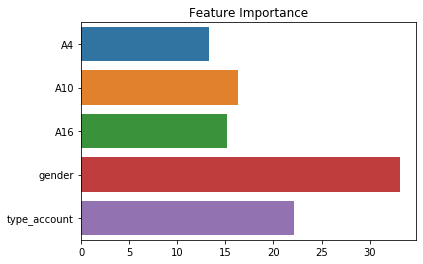

In [387]:
final_columns = final_continuous_variables + final_categorical_variables

sns.barplot(cb_model.feature_importances_.round(3),
            final_columns)

plt.title('Feature Importance')
plt.show()

# Comparing models

In [409]:
print(f"Decision Tree: {recall_score(y_test, y_test_dt, labels=['A','D'],pos_label='A'):.3f}")
print(f"Random Forest: {recall_score(y_test, y_test_rf, labels=['A','D'],pos_label='A'):.3f}")
print(f"AdaBoost: {recall_score(y_test, y_test_ada, labels=['A','D'],pos_label='A'):.3f}")
print(f"Gradient Boost: {recall_score(y_test, y_test_gb, labels=['A','D'],pos_label='A'):.3f}")
print(f"XGradient Boost: {recall_score(y_test, y_test_xgb, labels=['A','D'],pos_label='A'):.3f}")
print(f"CatBoost: {recall_score(cat_y_test, y_test_cb):.3f}")

Decision Tree: 0.998
Random Forest: 0.998
AdaBoost: 1.000
Gradient Boost: 0.998
XGradient Boost: 0.998
CatBoost: 0.841


In [413]:
final_columns

['A4', 'A10', 'A16', 'gender', 'type_account']

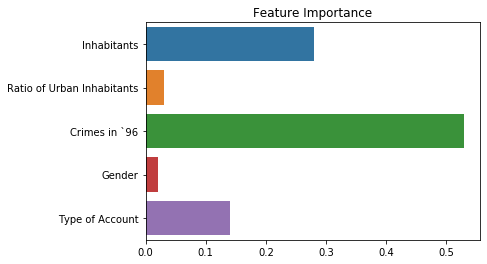

In [420]:
sns.barplot(final_ada[-1].feature_importances_.round(3),
            ['Inhabitants', 'Ratio of Urban Inhabitants', 'Crimes in `96', 'Gender', 'Type of Account'])

plt.title('Feature Importance')
plt.show()